In [1]:
import os
import numpy as np
import pandas as pd
import umap
import time
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)

/home/franco/miniconda3/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/franco/miniconda3/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/franco/miniconda3/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWa

In [2]:
# import bio_embeddings
from bio_embeddings.embed import ProtTransT5XLU50Embedder, ESM1bEmbedder # ProtTransBertBFDEmbedder #, 
from Bio import SeqIO
import numpy as np

halft5_dir = "./models/half_prottrans_t5_xl_u50/"

embedding_data = {}
embedding_data['halft5'] = { 'dir': halft5_dir }
sel_embedding = 'halft5'

In [3]:
embedder = ProtTransT5XLU50Embedder(model_directory=embedding_data[sel_embedding]['dir'], half_model=True)

You are using the legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565


In [4]:
### Load more detailed annotation for disprot

import json
disprot_json_file = "./disprot/DisProt_release_2022_06_with_ambiguous_evidences.json"
with open(disprot_json_file) as infmt:
    json_dict = json.load(infmt)

json_dict['data'][1]['regions'][0]
print(json_dict['data'][1]["acc"])

P49913


In [6]:
# Alphafold data for disprot sequences
af2_file = "AF2_testset.json"

# Monomer data
mono_file = "monomer_datadict.json"

with open(af2_file) as infmt:
    af2_dict = json.load(infmt)

with open(mono_file) as infmt:
    mono_dict = json.load(infmt)

all_dict = {**af2_dict, **mono_dict}
protein_ids = list(all_dict.keys())


In [9]:
embeddings = list()    

for prot in protein_ids:
    aa_sequence = all_dict[prot]['seq']
    ## get the embedding
    emb = embedder.embed(aa_sequence)
    embeddings.append(emb)

In [11]:
### Get disorder content
def get_disorder_content(annot):
    contents = [ x != "-" for x in annot]
    DC = np.sum(contents) / len(contents)
    return DC

for prot in protein_ids:
    dc = get_disorder_content(all_dict[prot]['disorder'])
    print(dc)

1.0
0.3816793893129771
0.5625
0.5773195876288659
0.8656716417910447
0.6978557504873294
0.6334405144694534
0.48402948402948404
0.48497854077253216
0.41935483870967744
0.03910614525139665
0.0
0.0
0.0
0.0
0.04697986577181208
0.0
0.026455026455026454
0.0
0.07758620689655173
0.042105263157894736


In [14]:
concat_emb = np.vstack(embeddings)

In [15]:
concat_emb.shape

(5773, 1024)

In [64]:
neighbours = 25
mindist = 0.25
my_umap = umap.UMAP(n_neighbors=neighbours, min_dist=mindist)
umap_embed = my_umap.fit_transform(concat_emb)

In [154]:
## Prepare annotations to be coloured
concat_seqs = ""
concat_disorder = ""
concat_ss = []
concat_plddt = []
concat_seqorig = []
for i,prot in enumerate(protein_ids):
    concat_seqs += all_dict[prot]['seq']
    concat_seqorig += [str(i) for j in range(len(all_dict[prot]['seq']))]
    concat_disorder += all_dict[prot]['disorder']
    concat_ss += all_dict[prot]['ss']
    if "pLDDT" in all_dict[prot]:
        concat_plddt += [float(x) for x in all_dict[prot]["pLDDT"]]
    else:
        tmp_plddt = list()
        for x in all_dict[prot]['disorder']:
            if x == "-":
                tmp_plddt.append(100.0)
            else:
                tmp_plddt.append(0.0)
        concat_plddt += tmp_plddt
AAs = sorted(list(set([x for x in concat_seqs])))
Disorders = sorted(list(set([x for x in concat_disorder])))
SSs = sorted(list(set(concat_ss)))

In [98]:
print(Disorders)
print(SSs)


['-', 'D', 'F', 'S', 'T']
['-', 'B', 'H']


In [93]:
a = [x for x in concat_seqs]
for aa in AAs:
    print(aa, a.count(aa))

A 519
C 116
D 266
E 322
F 171
G 469
H 138
I 182
K 352
L 456
M 114
N 197
P 474
Q 267
R 282
S 534
T 313
V 349
W 72
Y 180


In [67]:
aa_means = dict()
for aa in AAs:
    AAix = [x for x in range(0, len(concat_seqs)) if concat_seqs[x] == aa]
    embed_aa = umap_embed[AAix,:]
    x_mean = np.mean(embed_aa[:,0])
    y_mean = np.mean(embed_aa[:,1])
    aa_means[aa] = (x_mean, y_mean)

/tmp/ipykernel_7033/3287504656.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_rainbow', len(AAs))


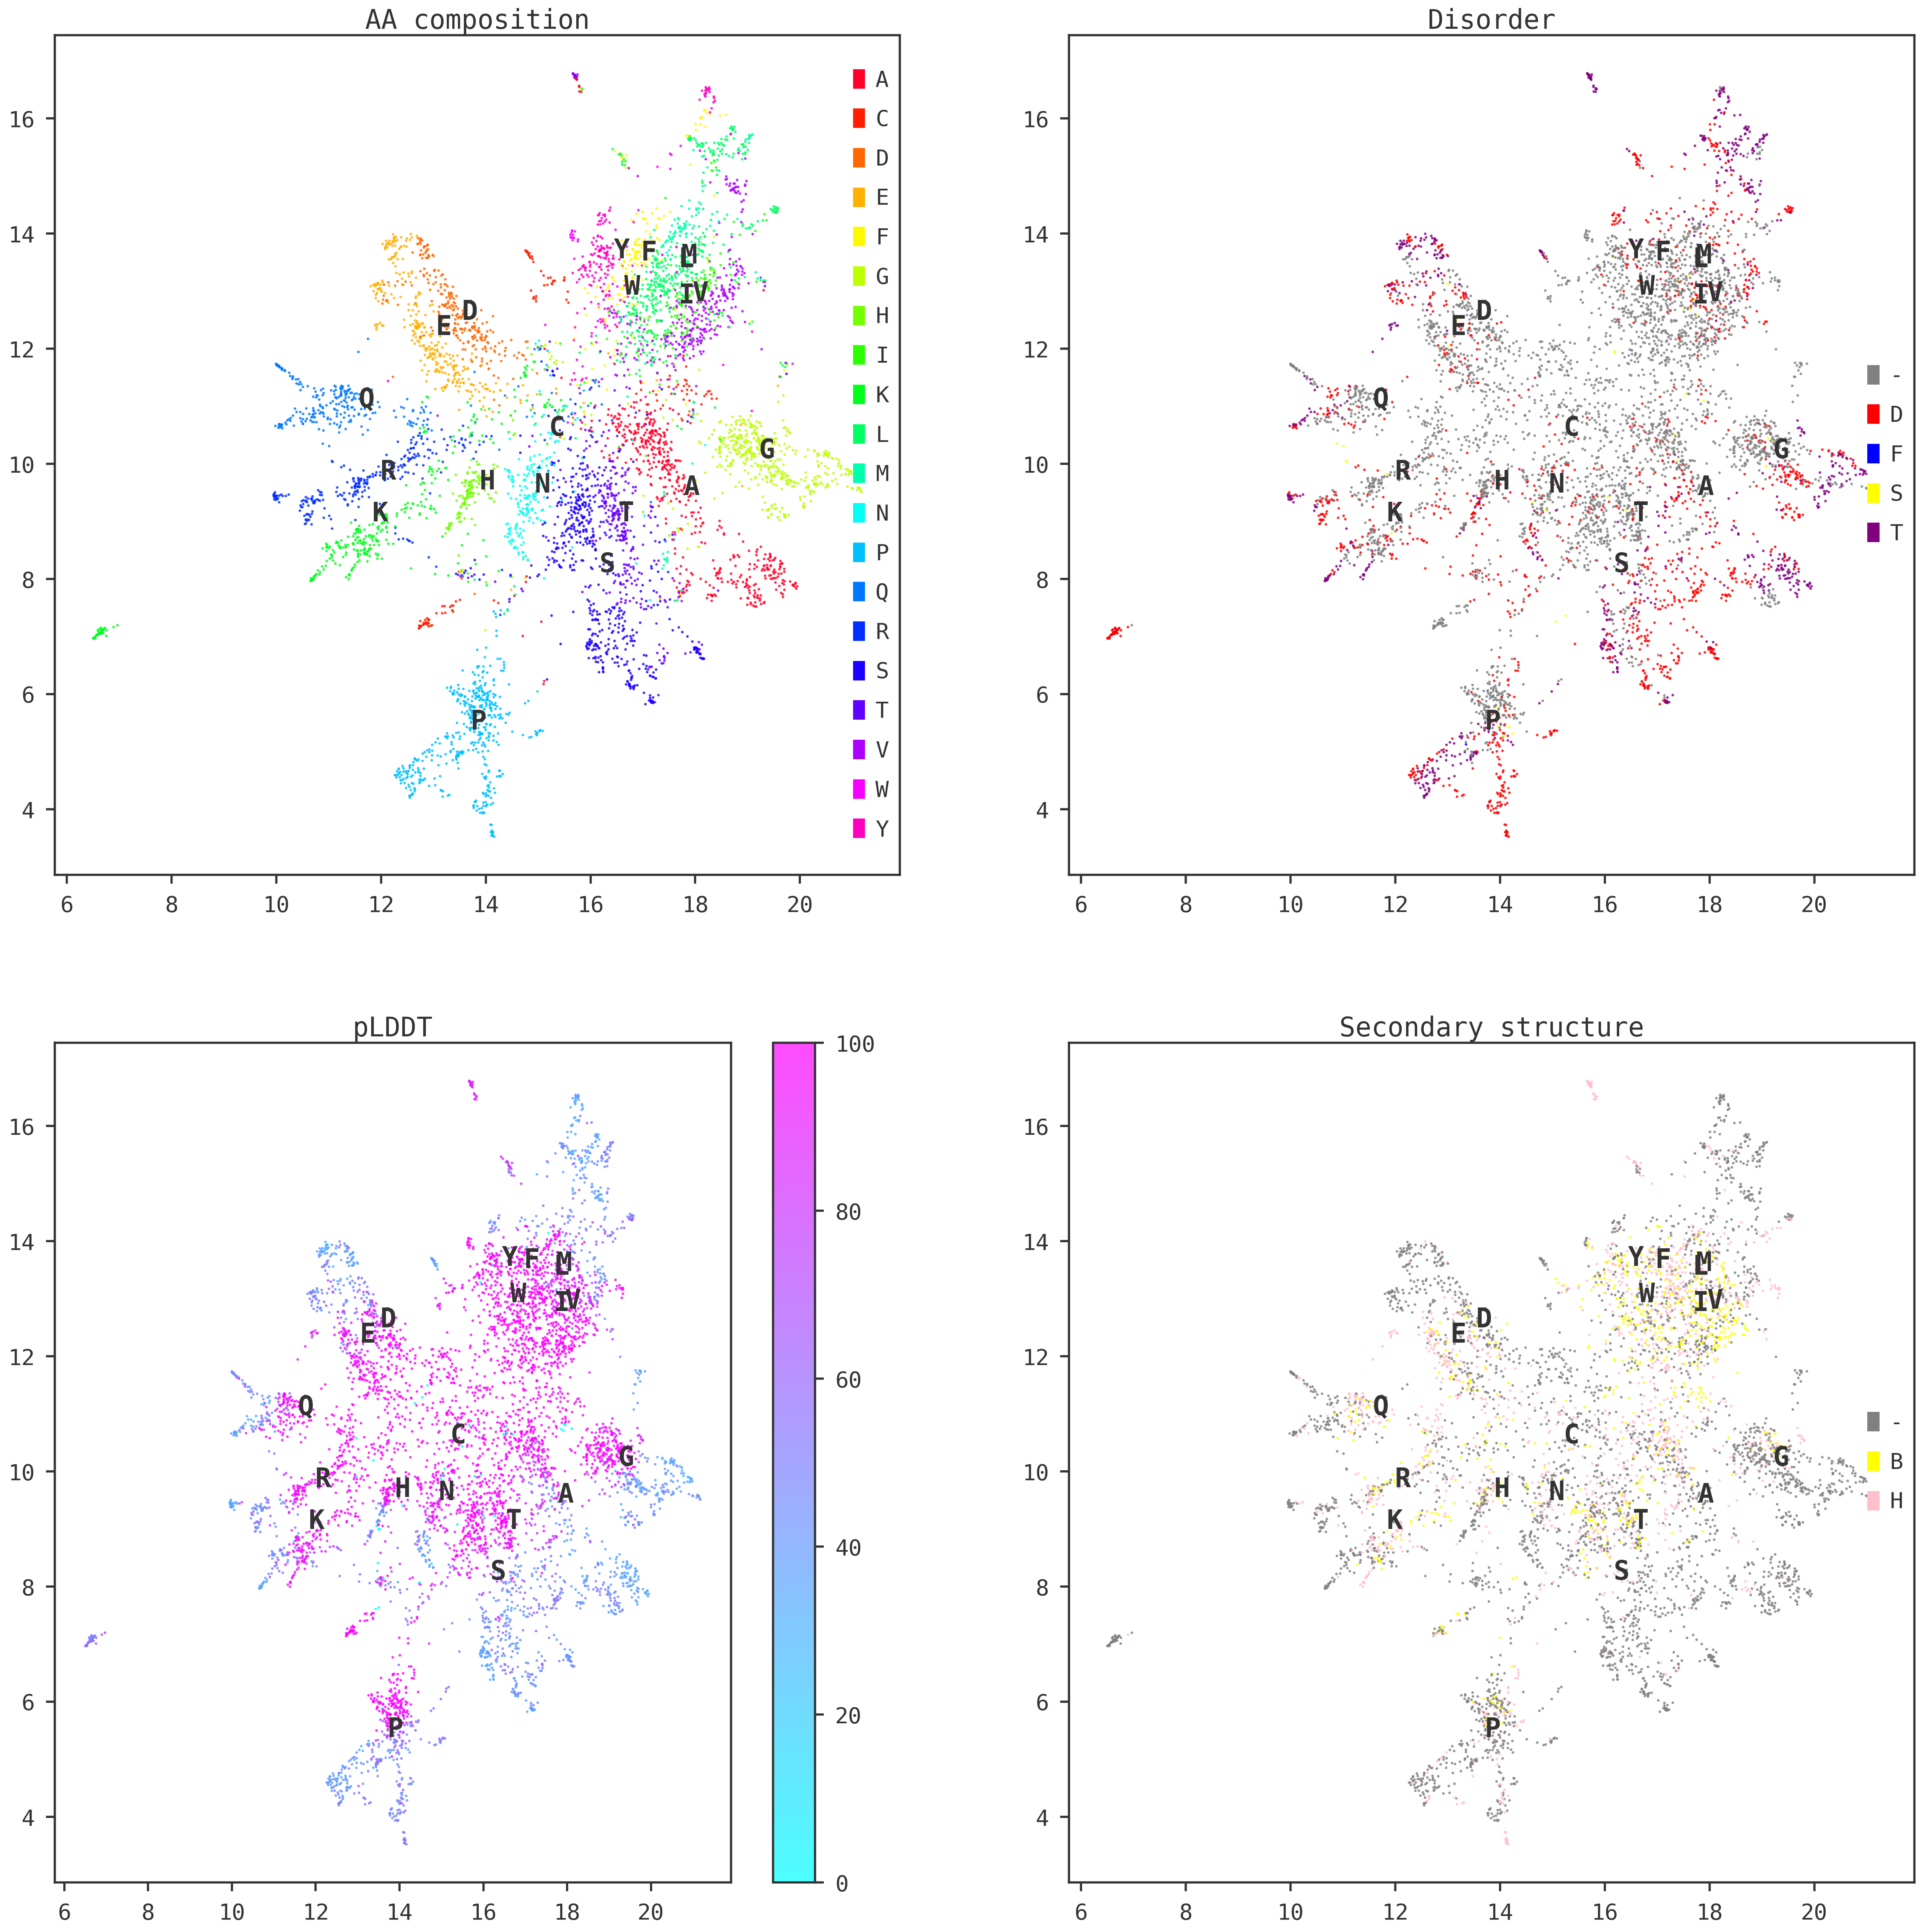

In [122]:
from matplotlib import cm, colormaps
from matplotlib.patches import Patch

cmap = cm.get_cmap('gist_rainbow', len(AAs))
colordict = dict(zip(AAs, np.arange(0, len(AAs))))

fig = plt.figure(figsize=(30,30), dpi=200)


## Paint aminoacids
ax = fig.add_subplot(221)
ax.scatter(umap_embed[:,0], umap_embed[:,1], s=2, alpha=0.7, c=[cmap(colordict[x]) for x in concat_seqs])

for aa in aa_means.keys():
    ax.text(aa_means[aa][0], aa_means[aa][1], aa, fontsize='large', fontweight='bold')

legend_elements = [Patch(facecolor=cmap(colordict[x]), edgecolor=cmap(colordict[x]),label=x) for x in AAs]
ax.legend(handles=legend_elements, loc='right')
ax.set_title("AA composition")

## ['-', 'D', 'F', 'S', 'T']
colors = ["gray", "red", "blue", "yellow", "purple"]
colordict = dict(zip(Disorders, colors))

### Paint disorder
ax2 = fig.add_subplot(222)
ax2.scatter(umap_embed[:,0], umap_embed[:,1], s=2, alpha=0.7, c=[colordict[x] for x in concat_disorder])

for aa in aa_means.keys():
    ax2.text(aa_means[aa][0], aa_means[aa][1], aa, fontsize='large', fontweight='bold')

legend_elements = [Patch(facecolor=colordict[x], edgecolor=colordict[x],label=x) for x in Disorders]
ax2.legend(handles=legend_elements, loc='right')
ax2.set_title("Disorder")


### Paint pLDDTs
cmapcont = colormaps['cool']

ax3 = fig.add_subplot(223)
cb = ax3.scatter(umap_embed[:,0], umap_embed[:,1], s=2, alpha=0.7, c=[x for x in concat_plddt], cmap=cmapcont)
cbar = fig.colorbar(cb, ax=ax3)

for aa in aa_means.keys():
    ax3.text(aa_means[aa][0], aa_means[aa][1], aa, fontsize='large', fontweight='bold')
ax3.set_title("pLDDT")

### Paint Secondary Structure
## ['-', 'B', 'H']
sscolors = ["gray", "yellow", "pink"]
sscolordict = dict(zip(SSs, sscolors))

ax4 = fig.add_subplot(224)
ax4.scatter(umap_embed[:,0], umap_embed[:,1], s=2, alpha=0.7, c=[sscolordict[x] for x in concat_ss])


for aa in aa_means.keys():
    ax4.text(aa_means[aa][0], aa_means[aa][1], aa, fontsize='large', fontweight='bold')

legend_elements = [Patch(facecolor=sscolordict[x], edgecolor=sscolordict[x],label=x) for x in SSs]
ax4.legend(handles=legend_elements, loc='right')
ax4.set_title("Secondary structure")

plt.savefig(f"plots/all_testset.png", bbox_inches='tight')
plt.show()

In [ ]:
## Keep UMAP embedding and plot one aminoacid

for targetAA in AAs:
    #targetAA = "E"

    AA_ix = [i for i in range(0, len(concat_seqs)) if concat_seqs[i]==targetAA]
    sub_umap_embed = umap_embed[AA_ix,:]

    cmap = cm.get_cmap('gist_rainbow', len(protein_ids))
    fig = plt.figure(figsize=(30,30), dpi=200)

    ## Paint aminoacids
    ax = fig.add_subplot(221)
    ax.scatter(sub_umap_embed[:,0], sub_umap_embed[:,1], s=50, alpha=0.9, c=[cmap(int(x)) for x in [concat_seqorig[i] for i in AA_ix]])
    legend_elements = [Patch(facecolor=cmap(int(x)), edgecolor=cmap(int(x)),label=x) for x in sorted(list(set(concat_seqorig)))]
    ax.legend(handles=legend_elements, loc='right')
    ax.set_title("AA composition")

    ## ['-', 'D', 'F', 'S', 'T']
    colors = ["gray", "red", "blue", "yellow", "purple"]
    colordict = dict(zip(Disorders, colors))

    ### Paint disorder
    ax2 = fig.add_subplot(222)
    ax2.scatter(sub_umap_embed[:,0], sub_umap_embed[:,1], s=50, alpha=0.9, c=[colordict[x] for x in [concat_disorder[i] for i in AA_ix]])
    legend_elements = [Patch(facecolor=colordict[x], edgecolor=colordict[x],label=x) for x in Disorders]
    ax2.legend(handles=legend_elements, loc='right')
    ax2.set_title("Disorder")


    ### Paint pLDDTs
    cmapcont = colormaps['cool']

    ax3 = fig.add_subplot(223)
    cb = ax3.scatter(sub_umap_embed[:,0], sub_umap_embed[:,1], s=50, alpha=0.9, c=[x for x in [concat_plddt[i] for i in AA_ix]], cmap=cmapcont)
    cbar = fig.colorbar(cb, ax=ax3)
    ax3.set_title("pLDDT")

    ### Paint Secondary Structure
    ## ['-', 'B', 'H']
    sscolors = ["gray", "yellow", "pink"]
    sscolordict = dict(zip(SSs, sscolors))

    ax4 = fig.add_subplot(224)
    ax4.scatter(sub_umap_embed[:,0], sub_umap_embed[:,1], s=50, alpha=0.9, c=[sscolordict[x] for x in [concat_ss[i] for i in AA_ix]])
    legend_elements = [Patch(facecolor=sscolordict[x], edgecolor=sscolordict[x],label=x) for x in SSs]
    ax4.legend(handles=legend_elements, loc='right')
    ax4.set_title("Secondary structure")

    plt.savefig(f"plots/{targetAA}.png", bbox_inches='tight')
    #plt.show()

In [ ]:
## same thing but recalculate the embedding for a single AA

for targetAA in AAs:

#     targetAA = "E"
    AA_ix = [i for i in range(0, len(concat_seqs)) if concat_seqs[i]==targetAA]

    neighbours = 25
    mindist = 0.1
    my_umap = umap.UMAP(n_neighbors=neighbours, min_dist=mindist)
    sub_umap_embed = my_umap.fit_transform(concat_emb[AA_ix,:])

    cmap = cm.get_cmap('gist_rainbow', len(protein_ids))

    fig = plt.figure(figsize=(30,30), dpi=150)


    ## Paint aminoacids by sequence of origin
    ax = fig.add_subplot(221)
    ax.scatter(sub_umap_embed[:,0], sub_umap_embed[:,1], s=50, alpha=0.9, c=[cmap(int(x)) for x in [concat_seqorig[i] for i in AA_ix]])
    legend_elements = [Patch(facecolor=cmap(int(x)), edgecolor=cmap(int(x)),label=x) for x in sorted(list(set(concat_seqorig)))]
    ax.legend(handles=legend_elements, loc='right')
    ax.set_title("AA composition")

    ## ['-', 'D', 'F', 'S', 'T']
    colors = ["gray", "red", "blue", "yellow", "purple"]
    colordict = dict(zip(Disorders, colors))

    ### Paint disorder
    ax2 = fig.add_subplot(222)
    ax2.scatter(sub_umap_embed[:,0], sub_umap_embed[:,1], s=50, alpha=0.9, c=[colordict[x] for x in [concat_disorder[i] for i in AA_ix]])

    legend_elements = [Patch(facecolor=colordict[x], edgecolor=colordict[x],label=x) for x in Disorders]
    ax2.legend(handles=legend_elements, loc='right')
    ax2.set_title("Disorder")


    ### Paint pLDDTs
    cmapcont = colormaps['cool']

    ax3 = fig.add_subplot(223)
    cb = ax3.scatter(sub_umap_embed[:,0], sub_umap_embed[:,1], s=50, alpha=0.9, c=[x for x in [concat_plddt[i] for i in AA_ix]], cmap=cmapcont)
    cbar = fig.colorbar(cb, ax=ax3)
    ax3.set_title("pLDDT")

    ### Paint Secondary Structure
    ## ['-', 'B', 'H']
    sscolors = ["gray", "yellow", "pink"]
    sscolordict = dict(zip(SSs, sscolors))

    ax4 = fig.add_subplot(224)
    ax4.scatter(sub_umap_embed[:,0], sub_umap_embed[:,1], s=50, alpha=0.9, c=[sscolordict[x] for x in [concat_ss[i] for i in AA_ix]])

    legend_elements = [Patch(facecolor=sscolordict[x], edgecolor=sscolordict[x],label=x) for x in SSs]
    ax4.legend(handles=legend_elements, loc='right')
    ax4.set_title("Secondary structure")

    plt.savefig(f"plots/reumap_{targetAA}.png", bbox_inches='tight')
    # plt.show()